## Import dependencies

In [ ]:
pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchvision.ops import Conv2dNormActivation

from dataclasses import dataclass
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sn

import matplotlib.pyplot as plt
import time
import numpy as np
import random
import warnings
import os
from tqdm import tqdm

import pandas as pd

%matplotlib inline
warnings.filterwarnings("ignore")

In [ ]:
#Set seed for reproducibilty
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
       torch.cuda.manual_seed(seed)
       torch.cuda.manual_seed_all(seed)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = True

set_seed(42)

## Download dataset

In [ ]:
!wget -q "https://www.dropbox.com/s/45jdd8padeyjq6t/10_Monkey_Species.zip?dl=1" -O "10_Monkey_Species.zip"

In [ ]:
!unzip -q "10_Monkey_Species.zip"

In [ ]:
@dataclass(frozen=True)
class TrainingConfig:
      ''' Configuration for Training '''
      batch_size: int = 32
      num_epochs: int = 25
      learning_rate: float = 1e-4

      log_interval: int = 1
      test_interval: int = 1
      data_root: int = "./"
      num_workers: int = 5
      device: str = "cuda"

train_config = TrainingConfig()
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print("Available Device: ", DEVICE)

Available Device:  cuda


In [ ]:
train_root = os.path.join("10_Monkey_Species", "training", "training")
val_root = os.path.join(train_config.data_root, "10_Monkey_Species", "validation", "validation")

In [ ]:
import cv2
Images = []
for label in os.listdir(train_root):
  class_path = os.path.join(train_root, label)
  for image in os.listdir(class_path):
    image_path = os.path.join(class_path, image)
    img = cv2.imread(image_path)
    Images.append(img)




KeyboardInterrupt: 

In [ ]:
len(Images)

1098

In [ ]:
df = pd.read_csv(os.path.join("10_Monkey_Species","monkey_labels.txt"), sep=",", header=None)
df.columns = ["Label", "Latin Name", "Common Name", "Train Images", "Validation Images"]
df['Latin Name'] = df['Latin Name'].str.replace("\t", " ")
df[1:]

,Label,Latin Name,Common Name,Train Images,Validation Images
1,n0,alouatta_palliata,mantled_howler,131,26
2,n1,erythrocebus_patas,patas_monkey,139,28
3,n2,cacajao_calvus,bald_uakari,137,27
4,n3,macaca_fuscata,japanese_macaque,152,30
5,n4,cebuella_pygmea,pygmy_marmoset,131,26
6,n5,cebus_capucinus,white_headed_capuchin,141,28
7,n6,mico_argentatus,silvery_marmoset,132,26
8,n7,saimiri_sciureus,common_squirrel_monkey,142,28
9,n8,aotus_nigriceps,black_headed_night_monkey,133,27
10,n9,trachypithecus_johnii,nilgiri_langur,132,26


## Dataset Preprocessing

In [ ]:
mean = [0.4368, 0.4336, 0.3294]  #mean and std of this Monkey Species dataset
std = [0.2457, 0.2413, 0.2447]


img_size = (224,224)

preprocess = transforms.Compose(
    [
        transforms.Resize(img_size, antialias=True),
        transforms.ToTensor()
    ]
)

In [ ]:
common_transforms = transforms.Compose(
    [
        preprocess,
        transforms.Normalize(mean=mean,std=std)
    ]
)

train_transforms = transforms.Compose(
    [
        preprocess,
        transforms.RandomHorizontalFlip(),

        transforms.RandomErasing(p=0.4),
        transforms.RandomApply([
        transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
         ], p =0.1),

        transforms.Normalize(mean = mean,std = std)
    ]
)

In [ ]:
#Apply augmentations to the training dataset
train_data = datasets.ImageFolder(root = train_root, transform = train_transforms)

# The validation dataset should have only common transforms like Resize, ToTensor and Normalize.
val_data = datasets.ImageFolder(root=val_root, transform = common_transforms)
train_data.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [ ]:

len(train_data)

1097

In [ ]:
train_data.class_to_idx

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [ ]:
len(train_data)

1097

In [ ]:
train_loader = DataLoader(
    train_data,
    shuffle = True,
    batch_size = train_config.batch_size,
    num_workers = train_config.num_workers
)
val_loader = DataLoader(
    val_data,
    shuffle = False,
    batch_size = train_config.batch_size,
    num_workers = train_config.num_workers
)

In [ ]:
print(len(train_loader))

35


In [ ]:
class_mapping = {

    0: "mantled_howler",
    1: "patas_monkey",
    2: "bald_uakari",
    3: "japanese_macaque",
    4: "pygmy_marmoset",
    5: "white_headed_capuchin",
    6: "silvery_marmoset",
    7: "common_squirrel_monkey",
    8: "black_headed_night_monkey",
    9: "nilgiri_langur"
}

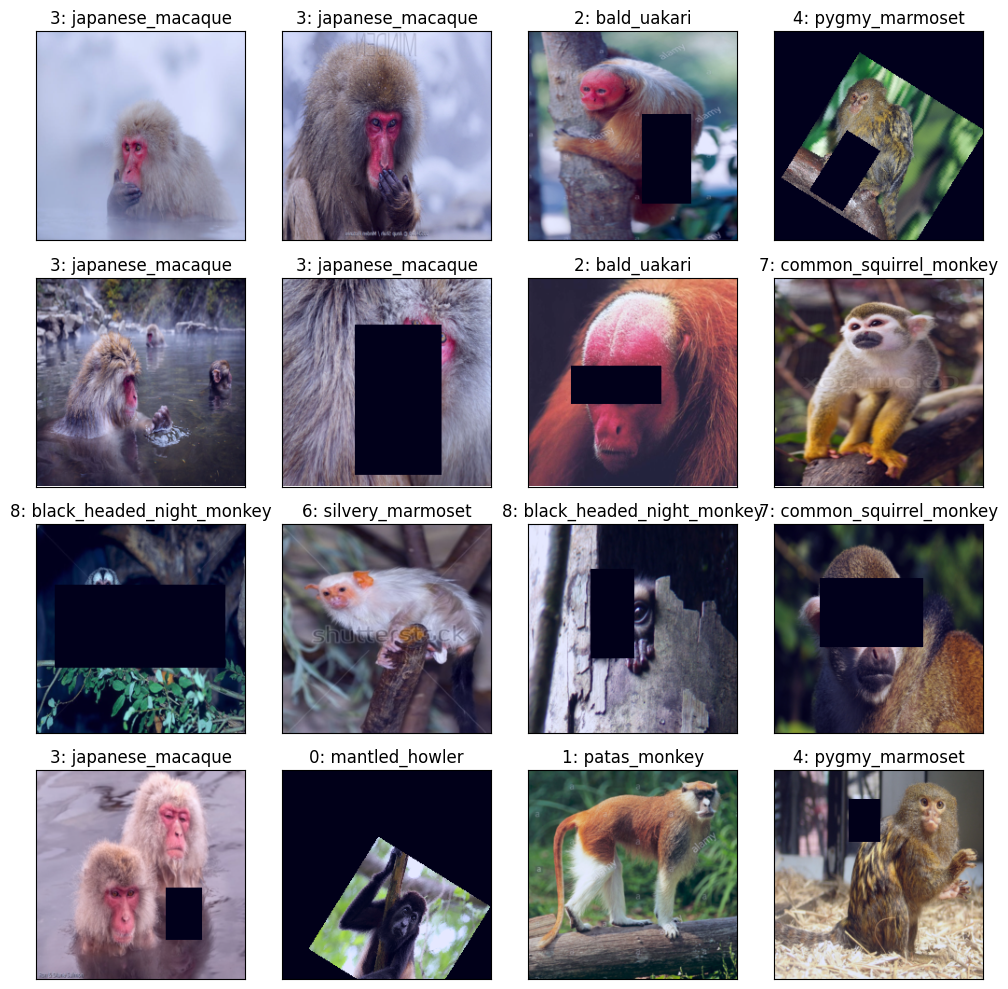

In [ ]:
def visualize_images(dataloader, num_images = 20):
    fig = plt.figure(figsize=(10,10))

    #Iterate over the first batch
    images, labels = next(iter(dataloader))
    # print(images.shape)

    num_rows = 4
    num_cols = int(np.ceil((num_images / num_rows)))

    for idx in range(min(num_images, len(images))):
        image, label = images[idx], labels[idx]


        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks = [], yticks = [])

        image = image.permute(1,2,0)

        #Normalize the image to [0,1] to display

        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image, cmap="gray")  # remove the batch dimension
        ax.set_title(f"{label.item()}: {class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()

visualize_images(train_loader, num_images = 16)

In [ ]:
class MyModel(nn.Module):
  def __init__(self):
    super().__init__()

    self._model = nn.Sequential(

        #---------------------- Convolution Layers ----------------------

        #-----------------------------------------------
        # Conv2d Norm Activation Block1: 32 Filters, MaxPool.
        #-----------------------------------------------
        nn.Conv2d(in_channels = 3, out_channels = 84, kernel_size = 3),
        nn.BatchNorm2d(84),
        nn.ReLU(inplace = True),

        nn.Conv2d(in_channels = 84, out_channels = 84, kernel_size = 3),
        nn.BatchNorm2d(84),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2),

        #-------------------------------------------------------------------
        # Conv2d Norm Activation Block 2: 64,128 Filters, MaxPool, Dropout(p=0.25)
        #-------------------------------------------------------------------
        nn.LazyConv2d(out_channels = 128, kernel_size = 3),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace = True),

        nn.LazyConv2d(out_channels = 256, kernel_size = 3),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2),

        #--------------------------------------------------
        # Conv2d Norm Activation Block 3: 128,256,512 Filters, MaxPool.
        #--------------------------------------------------
        nn.LazyConv2d(out_channels = 256 , kernel_size = 3),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True),

        nn.LazyConv2d(out_channels = 512, kernel_size = 3),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2),
        nn.Dropout(0.25),

        nn.LazyConv2d(out_channels = 512, kernel_size = 3),
        nn.BatchNorm2d(512), # nn.BatchNorm2d normalizes the activations (outputs) of a convolutional layer for each batch during training.
                             # It makes sure that each feature map has mean ≈ 0 and standard deviation ≈ 1 — helping the network learn faster and more stably.
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2), #It divides the input feature map into non-overlapping 2×2 blocks, and from each block, it keeps only the maximum value.
                                       #Max pooling is a downsampling operation used in CNNs to: reduce the spatial size (height × width) of feature maps, keep the most important features, and


        #---------------------- Feed Forward Layers --------------------
        nn.AdaptiveAvgPool2d(output_size=(3,3)), # “Whatever the current spatial size of my feature maps is, resize it so the output becomes exactly 3×3 for each channel.”

        #------------------------------------
        # Flatten the convolutional features.
        #------------------------------------
        nn.Flatten(),

        #--------------------
        # Classification Head.
        #--------------------
        nn.Linear(in_features = 512*3*3, out_features = 256),# nn.Linear is the fully connected (dense) layer in PyTorch
        nn.Dropout(0.3),
        nn.Linear(in_features = 256, out_features = 10) #criterion = nn.CrossEntropyLoss() The loss function automatically applies softmax internally on your model outputs (called logits),
    )

  def forward(self,x):
      return self._model(x)

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# assume your model is defined as MyModel
model = MyModel()
model.eval()  # turn off dropout/batchnorm randomness

# choose which layers to visualize
#layers_to_visualize = [0, 1, 2,]  # example indices inside nn.Sequential

# dictionary to store feature maps
features = {}

def get_activation(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

# register hooks for selected layers
for idx in range(len(model._model)):
    model._model[idx].register_forward_hook(get_activation(f"layer_{idx}"))


In [ ]:
print(len(model._model))
print(model._model[21])  # 0 3 7 14 17 21

31
Dropout(p=0.25, inplace=False)


In [ ]:
from torchvision import transforms
from PIL import Image

# Load and preprocess image
img = Image.open("/content/10_Monkey_Species/training/training/n2/n2147.jpg").convert("RGB")

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

x = transform(img).unsqueeze(0)  # shape: [1, 3, 128, 128]

# Forward pass
with torch.no_grad():
    _ = model(x)


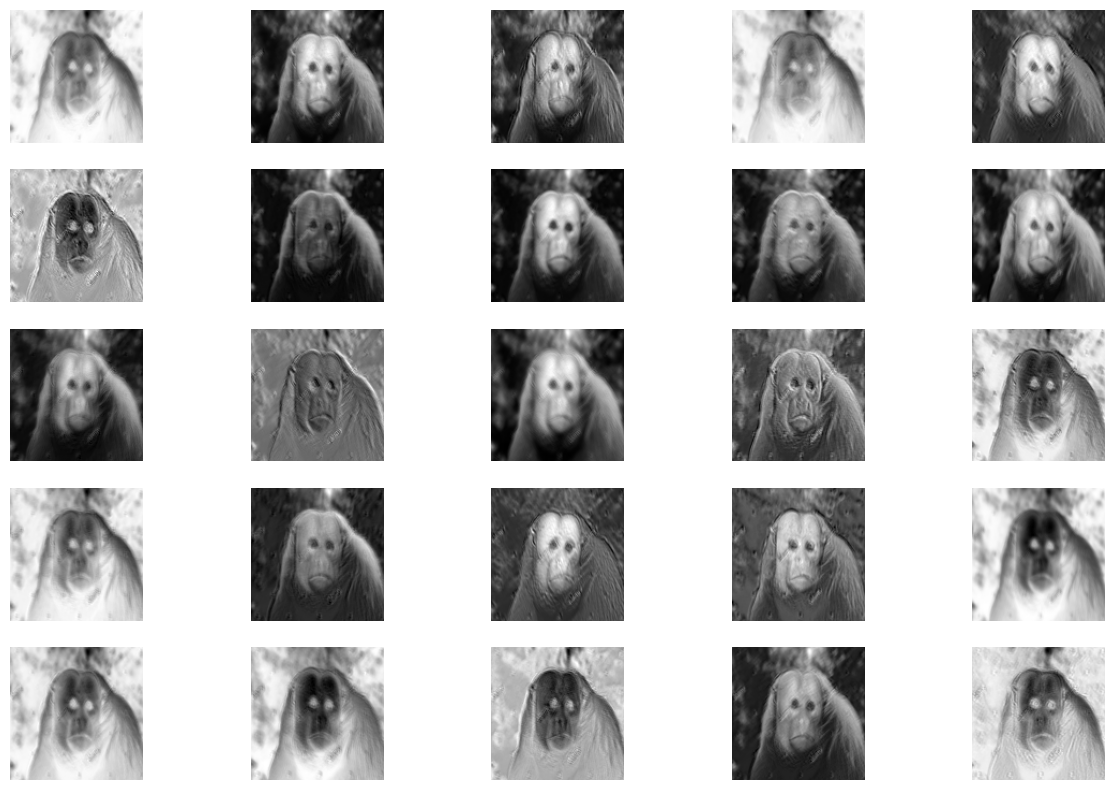

In [ ]:
def visualize_feature_maps(feature_tensor, num_maps=25):
    feature_tensor = feature_tensor.squeeze(0)  # remove batch dimension
    num_channels = feature_tensor.shape[0]

    plt.figure(figsize=(15, 10))
    for i in range(num_maps):
        plt.subplot(5, 5, i+1)
        plt.imshow(feature_tensor[i].cpu(), cmap='gray')
        plt.axis('off')
    plt.show()

# Example: visualize layer_0 features
visualize_feature_maps(features["layer_3"]) # 0 3 7 14 17 21


🔹 1. Overview of your conv layers

You listed these:

Layers: 0, 3, 7, 14, 17, 21


Each corresponds to deeper stages of your network — from low-level feature extraction to high-level abstraction.

Layer	Likely Operation	Observed Pattern	Meaning
0	Conv2d(3→32, 5x5)	Clear edges (sharp boundaries)	Detects edges, corners, and colors — classic low-level features. Each filter acts like a Sobel or Gabor detector.
3	Conv2d(32→32, 3x3)	Some edges, some blur	Combines multiple edges → detects patterns like lines, curves, blobs. Slight blur because of larger receptive fields.
7	Conv2d(32→64, 3x3)	More blurred textures	Extracts local textures or object parts. Multiple edge features get fused — less visually clear but more abstract.
14	Conv2d(128→256, 3x3)	Grids start appearing	Filters now capture combinations of textures or patterns — checker or grid-like responses.
17	Conv2d(256→256, 3x3)	Larger grids	Detects larger textures or structural motifs, not fine details. Spatial resolution has reduced.
21	Conv2d(256→512, 3x3)	Big black/white blocks	Deep, high-level semantic features — activation corresponds to “regions” or “concepts” (e.g., object parts).
🔹 2. Why this progressive change happens
a. Receptive field expansion

Each deeper layer “sees” a larger portion of the image:

Early: 3×3, 5×5 receptive fields (fine detail)

Deep: 40×40+ receptive fields (large context)

As a result, fine edges blur into coarse structures.

b. Pooling and stride effects

Each MaxPool or stride-2 convolution reduces spatial resolution.
Thus, the feature maps become:

smaller in width/height

more abstract (less local detail)

Hence the grid/block patterns you see in deeper layers.

c. Activation sparsity

ReLU zeroes out most weak activations → high contrast in deeper maps →
appearance of binary-like grids (active vs inactive regions).

🔹 3. How to interpret this evolution visually

This is called the feature hierarchy of CNNs:

Depth	Feature Type	Visual Appearance
Shallow (Layer 0–3)	Edges, corners, gradients	Sharp, clear patterns
Mid (Layer 7–14)	Textures, motifs	Blurry, patchy
Deep (Layer 17–21)	Semantic regions, object parts	Large black/white blobs

This is exactly how architectures like VGG, ResNet, or AlexNet learn — starting from pixels → to shapes → to concepts.

🔹 4. Validation — you’re observing representation abstraction

You’re literally watching representation abstraction happen layer by layer.

Here’s what your CNN is learning to “see”:

Layer 0: “Where are the edges?”

Layer 3: “Are these edges forming corners or contours?”

Layer 7: “Do these contours form patterns?”

Layer 14: “Are these patterns part of an object (like a texture or region)?”

Layer 17/21: “Which region corresponds to the class concept?”

In [ ]:
model = MyModel()

optimizer  = Adam(model.parameters(), lr = train_config.learning_rate)
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"

logdir = "runs/80epochs-3.3M_param_dropout"

writer = SummaryWriter(logdir)

dummy_input = (1,3,224,224)
print(summary(model, dummy_input, row_settings = ["var_names"],device="cpu"))

Layer (type (var_name))                  Output Shape              Param #
MyModel (MyModel)                        [1, 10]                   --
├─Sequential (_model)                    [1, 10]                   --
│    └─Conv2d (0)                        [1, 84, 222, 222]         2,352
│    └─BatchNorm2d (1)                   [1, 84, 222, 222]         168
│    └─ReLU (2)                          [1, 84, 222, 222]         --
│    └─Conv2d (3)                        [1, 84, 220, 220]         63,588
│    └─BatchNorm2d (4)                   [1, 84, 220, 220]         168
│    └─ReLU (5)                          [1, 84, 220, 220]         --
│    └─MaxPool2d (6)                     [1, 84, 110, 110]         --
│    └─Conv2d (7)                        [1, 128, 108, 108]        96,896
│    └─BatchNorm2d (8)                   [1, 128, 108, 108]        256
│    └─ReLU (9)                          [1, 128, 108, 108]        --
│    └─Conv2d (10)                       [1, 256, 106, 106]        295,

In [ ]:
def train(model, train_loader):
    model.train()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_train_samples = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_train_samples += labels.shape[0]
        correct_predictions += (predicted == labels).sum().item()

    train_avg_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_predictions / total_train_samples
    return train_avg_loss, train_accuracy

In [ ]:

def validation(model, val_loader):
    model.eval()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_val_samples = 0

    for images, labels in tqdm(val_loader, desc="Validation"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.no_grad():
             outputs = model(images)

        loss = F.cross_entropy(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_val_samples += labels.shape[0]
        correct_predictions += (predicted == labels).sum().item()

    val_avg_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct_predictions / total_val_samples
    return val_avg_loss, val_accuracy

In [ ]:

def main(model, train_loader, val_loader):

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = 0.0
    best_weights = None

    for epoch in range(train_config.num_epochs):
        train_loss, train_accuracy = train(model, train_loader)
        val_loss, val_accuracy = validation(model, val_loader)


        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1:0>2}/{train_config.num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Logging metrics to tensorboard
        writer.add_scalar('Loss/train', train_loss)
        writer.add_scalar('Loss/val', val_loss)
        writer.add_scalar('Accuracy/train', train_accuracy)
        writer.add_scalar('Accuracy/val', val_accuracy)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_weights =  model.state_dict()
            print(f"Saving best model...💾")
            torch.save(best_weights, "best.pt")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = main(model, train_loader, val_loader)

Validation: 100%|██████████| 9/9 [00:06<00:00,  1.50it/s]


Epoch 01/25 - Train Loss: 1.8956, Train Accuracy: 30.99% - Val Loss: 1.7220, Val Accuracy: 38.60%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


Epoch 02/25 - Train Loss: 1.4410, Train Accuracy: 48.77% - Val Loss: 1.3119, Val Accuracy: 55.51%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.56it/s]


Epoch 03/25 - Train Loss: 1.2977, Train Accuracy: 54.15% - Val Loss: 1.2993, Val Accuracy: 56.25%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 04/25 - Train Loss: 1.2327, Train Accuracy: 55.88% - Val Loss: 1.1053, Val Accuracy: 64.71%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


Epoch 05/25 - Train Loss: 1.1561, Train Accuracy: 59.98% - Val Loss: 1.0922, Val Accuracy: 61.76%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]


Epoch 06/25 - Train Loss: 1.1134, Train Accuracy: 62.26% - Val Loss: 1.0238, Val Accuracy: 65.44%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 07/25 - Train Loss: 0.9860, Train Accuracy: 66.27% - Val Loss: 0.9122, Val Accuracy: 67.28%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


Epoch 08/25 - Train Loss: 0.9791, Train Accuracy: 65.18% - Val Loss: 0.9207, Val Accuracy: 65.81%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 09/25 - Train Loss: 0.8668, Train Accuracy: 70.37% - Val Loss: 0.8587, Val Accuracy: 70.22%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.56it/s]


Epoch 10/25 - Train Loss: 0.8506, Train Accuracy: 71.01% - Val Loss: 0.7973, Val Accuracy: 70.22%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]


Epoch 11/25 - Train Loss: 0.8182, Train Accuracy: 71.74% - Val Loss: 1.0788, Val Accuracy: 67.65%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 12/25 - Train Loss: 0.7450, Train Accuracy: 75.11% - Val Loss: 0.9234, Val Accuracy: 66.54%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


Epoch 13/25 - Train Loss: 0.7501, Train Accuracy: 74.48% - Val Loss: 0.8429, Val Accuracy: 71.69%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


Epoch 14/25 - Train Loss: 0.6785, Train Accuracy: 77.94% - Val Loss: 1.0221, Val Accuracy: 67.65%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


Epoch 15/25 - Train Loss: 0.7413, Train Accuracy: 72.65% - Val Loss: 1.2370, Val Accuracy: 63.60%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]


Epoch 16/25 - Train Loss: 0.7153, Train Accuracy: 75.57% - Val Loss: 0.7456, Val Accuracy: 76.84%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 17/25 - Train Loss: 0.6433, Train Accuracy: 78.03% - Val Loss: 0.8237, Val Accuracy: 72.43%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


Epoch 18/25 - Train Loss: 0.6800, Train Accuracy: 76.48% - Val Loss: 0.9116, Val Accuracy: 73.53%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 19/25 - Train Loss: 0.5931, Train Accuracy: 80.40% - Val Loss: 0.6875, Val Accuracy: 77.57%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


Epoch 20/25 - Train Loss: 0.5938, Train Accuracy: 80.67% - Val Loss: 0.7195, Val Accuracy: 73.90%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 21/25 - Train Loss: 0.6055, Train Accuracy: 79.85% - Val Loss: 0.6449, Val Accuracy: 79.04%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.54it/s]


Epoch 22/25 - Train Loss: 0.5752, Train Accuracy: 80.22% - Val Loss: 0.7438, Val Accuracy: 74.63%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 23/25 - Train Loss: 0.5293, Train Accuracy: 82.41% - Val Loss: 0.7398, Val Accuracy: 76.84%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


Epoch 24/25 - Train Loss: 0.5315, Train Accuracy: 82.77% - Val Loss: 0.7451, Val Accuracy: 76.84%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]

Epoch 25/25 - Train Loss: 0.4641, Train Accuracy: 84.50% - Val Loss: 0.7155, Val Accuracy: 76.47%


In [ ]:
# Load the best model weights
model.load_state_dict(torch.load("best.pt"))
model.eval()

NameError: name 'model' is not defined

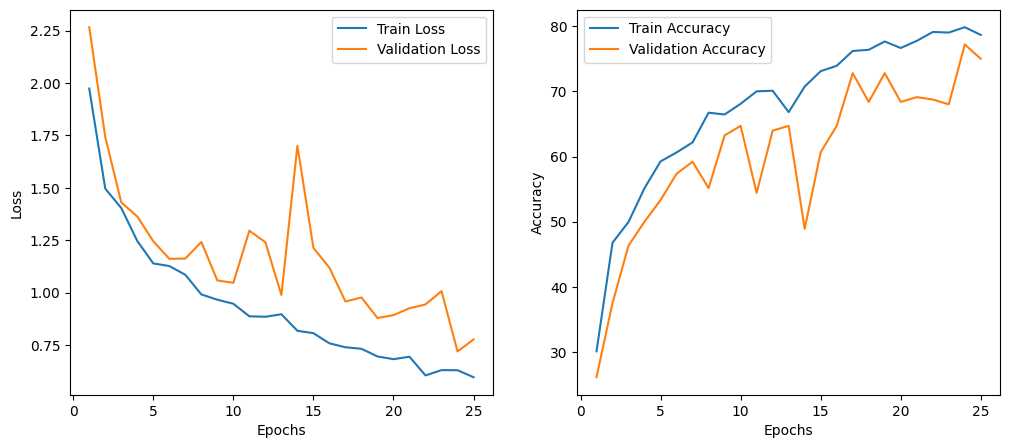

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,train_config.num_epochs + 1), train_losses, label = "Train Loss")
plt.plot(range(1, train_config.num_epochs + 1), val_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,train_config.num_epochs + 1), train_accuracies, label = "Train Accuracy")
plt.plot(range(1, train_config.num_epochs + 1), val_accuracies, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()